In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('dataset.csv')
df = df.drop(columns=['annotaters'], errors='ignore')

In [ ]:
def preprocess_data(df):
    df_clean = df.copy()
    
    df_clean['hate'] = df_clean['label'].map({'h': 1, 'nh': 0}) # binary hate, non-hate
    
    target_map = {'p': 0, 'e': 1, 'r': 2} # numeric mapping of target categories
    df_clean['target'] = df_clean['target'].str.lower().str.strip()
    
    # non-hate labels have no target
    df_clean['target'] = (
        df_clean['target']
        .map(target_map)
        .where(df_clean['target'].isin(target_map.keys()))
    )
    df_clean['target'] = df_clean['target'].fillna(-100).astype(int)
    
    invalid_hate_mask = (df_clean['hate'] == 1) & (df_clean['target'] == -100)
    df_clean.loc[invalid_hate_mask, 'hate'] = 0
    
    return df_clean

In [ ]:
def validate_dataset(df):
    assert set(df['hate'].unique()).issubset({0, 1}), f"Invalid hate labels: {df['hate'].unique()}"
    
    valid_targets = {-100, 0, 1, 2}
    invalid_targets = set(df['target'].unique()) - valid_targets
    assert not invalid_targets, f"Invalid targets detected: {invalid_targets}"
    
    nh_mask = df['hate'] == 0
    assert (df.loc[nh_mask, 'target'] == -100).all(), "Non-hate samples have invalid targets"
    
    assert not df['text'].isna().any(), "NaN in sentence column"
    assert not df['hate'].isna().any(), "NaN in hate column"
    assert not df['target'].isna().any(), "NaN in target column"
    
    print("All dataset validation checks passed!")

In [34]:
df_clean = preprocess_data(df)

validate_dataset(df_clean)

All dataset validation checks passed!


In [35]:
len(df_clean)

3597

In [36]:
import torch
from transformers import AutoTokenizer, AutoModel, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import numpy as np

class TurkishHateSpeechDataset(Dataset):
    def __init__(self, texts, hate_labels, target_labels, tokenizer, max_len=128):
        self.texts = texts
        self.hate_labels = hate_labels
        self.target_labels = target_labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'hate_labels': torch.tensor(self.hate_labels[idx], dtype=torch.float),
            'target_labels': torch.tensor(self.target_labels[idx], dtype=torch.long)
        }

In [37]:
class TurkishHateBERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")
        self.hate_head = torch.nn.Linear(768, 1)
        self.target_head = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.hate_head(pooled_output), self.target_head(pooled_output)

In [38]:
def prepare_loaders(df, tokenizer, batch_size=16):
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['hate'])
    
    train_dataset = TurkishHateSpeechDataset(
        train_df['text'].values,
        train_df['hate'].values,
        train_df['target'].values,
        tokenizer
    )
    
    test_dataset = TurkishHateSpeechDataset(
        test_df['text'].values,
        test_df['hate'].values,
        test_df['target'].values,
        tokenizer
    )

    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), \
           DataLoader(test_dataset, batch_size=batch_size)

In [39]:
def evaluate_model(model, dataloader, device):
    model.eval()
    hate_preds = []
    hate_probs = []
    true_hate = []
    target_preds = []
    true_target = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            hate_logits, target_logits = model(input_ids, attention_mask)
            
            # Hate predictions
            batch_probs = torch.sigmoid(hate_logits.squeeze()).cpu().numpy()
            batch_preds = (batch_probs > 0.5).astype(int)
            
            hate_probs.extend(batch_probs)
            hate_preds.extend(batch_preds)
            true_hate.extend(batch['hate_labels'].cpu().numpy())
            
            # Target predictions
            target_probs = torch.softmax(target_logits, dim=1).cpu().numpy()
            batch_target_preds = np.argmax(target_probs, axis=1)
            
            target_preds.extend(batch_target_preds)
            true_target.extend(batch['target_labels'].cpu().numpy())

    # Filter target predictions for valid labels
    target_mask = np.array(true_target) != -100
    filtered_target_pred = np.array(target_preds)[target_mask]
    filtered_true_target = np.array(true_target)[target_mask]

    return {
        'true_hate': true_hate,
        'pred_hate': hate_preds,
        'true_target': filtered_true_target,
        'pred_target': filtered_target_pred
    }

In [40]:
def train_model(model, train_loader, test_loader, device, epochs=4, lr=2e-5):
    optimizer = AdamW(model.parameters(), lr=lr)
    hate_criterion = torch.nn.BCEWithLogitsLoss()
    target_criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)
    
    best_f1 = 0
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            hate_labels = batch['hate_labels'].to(device)
            target_labels = batch['target_labels'].to(device)
            
            hate_logits, target_logits = model(input_ids, attention_mask)
            
            # Calculate losses
            hate_loss = hate_criterion(hate_logits.squeeze(), hate_labels)
            
            target_mask = (target_labels != -100)
            if target_mask.any():
                target_loss = target_criterion(
                    target_logits[target_mask],
                    target_labels[target_mask]
                )
            else:
                target_loss = torch.tensor(0.0).to(device)
                
            loss = hate_loss + target_loss
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        val_metrics = evaluate_model(model, test_loader, device)
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {total_loss/len(train_loader):.4f}")
        print("\nValidation Metrics:")
        print(classification_report(
            val_metrics['true_hate'], 
            val_metrics['pred_hate'], 
            target_names=['Non-Hate', 'Hate']
        ))
        print("\nTarget Classification (Hate Cases Only):")
        print(classification_report(
            val_metrics['true_target'], 
            val_metrics['pred_target'], 
            target_names=['Politics', 'Ethnicity', 'Race']
        ))

    return model

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

In [42]:
train_loader, test_loader = prepare_loaders(df_clean, tokenizer)

In [43]:
model = TurkishHateBERT()
trained_model = train_model(model, train_loader, test_loader, device)

/opt/homebrew/Caskroom/miniconda/base/envs/turkish-bert/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/4
Train Loss: 1.4856

Validation Metrics:
              precision    recall  f1-score   support

    Non-Hate       0.72      0.77      0.75       393
        Hate       0.70      0.64      0.67       327

    accuracy                           0.71       720
   macro avg       0.71      0.71      0.71       720
weighted avg       0.71      0.71      0.71       720


Target Classification (Hate Cases Only):
              precision    recall  f1-score   support

    Politics       0.82      0.78      0.80       125
   Ethnicity       0.79      0.88      0.83       135
        Race       0.77      0.66      0.71        67

    accuracy                           0.80       327
   macro avg       0.79      0.77      0.78       327
weighted avg       0.80      0.80      0.80       327


Epoch 2/4
Train Loss: 0.9863

Validation Metrics:
              precision    recall  f1-score   support

    Non-Hate       0.75      0.83      0.79       393
        Hate       0.77      0.66      

In [44]:
def predict(text, model, tokenizer, device):
    encoding = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to(device)
    
    model.eval()
    with torch.no_grad():
        hate_logits, target_logits = model(encoding['input_ids'], encoding['attention_mask'])
    
    hate_prob = torch.sigmoid(hate_logits).item()
    target_probs = torch.softmax(target_logits, dim=1).cpu().numpy()[0]
    
    return {
        'hate_probability': hate_prob,
        'target_probabilities': {
            'politics': target_probs[0],
            'ethnicity': target_probs[1],
            'race': target_probs[2]
        }
    }

In [45]:
sample_text = "Bu tam bir ırkçı söylem!"
print(predict(sample_text, trained_model, tokenizer, device))

{'hate_probability': 0.20786269009113312, 'target_probabilities': {'politics': 0.2015549, 'ethnicity': 0.3872825, 'race': 0.4111626}}


In [46]:
def evaluate_model(model, dataloader, device):
    model.eval()
    hate_probs = []
    hate_preds = []
    true_hate = []
    target_probs = []
    target_preds = []
    true_target = []
    target_mask = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            hate_logits, target_logits = model(input_ids, attention_mask)
            
            # Hate predictions
            batch_probs = torch.sigmoid(hate_logits.squeeze()).cpu().numpy()
            batch_preds = (batch_probs > 0.5).astype(int)
            
            hate_probs.extend(batch_probs)
            hate_preds.extend(batch_preds)
            true_hate.extend(batch['hate_labels'].cpu().numpy())
            
            # Target predictions
            batch_target_probs = torch.softmax(target_logits, dim=1).cpu().numpy()
            batch_target_preds = np.argmax(batch_target_probs, axis=1)
            
            target_probs.extend(batch_target_probs)
            target_preds.extend(batch_target_preds)
            true_target.extend(batch['target_labels'].cpu().numpy())
            target_mask.extend(batch['target_labels'].cpu().numpy() != -100)

    return {
        'true_hate': np.array(true_hate),
        'pred_hate': np.array(hate_preds),
        'hate_probs': np.array(hate_probs),
        'true_target': np.array(true_target)[np.array(target_mask)],
        'pred_target': np.array(target_preds)[np.array(target_mask)],
        'target_mask': np.array(target_mask)
    }

In [49]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_and_visualize(model, test_loader, device):
    test_metrics = evaluate_model(model, test_loader, device)
    
    print("\n" + "="*40)
    print("Hate Speech Detection Metrics")
    print("="*40)
    print(classification_report(
        test_metrics['true_hate'],
        test_metrics['pred_hate'],
        target_names=['Non-Hate', 'Hate']
    ))
    
    cm = confusion_matrix(test_metrics['true_hate'], test_metrics['pred_hate'])
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'])
    plt.title('Hate Speech Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('hate_confusion_matrix.png')
    plt.show()
    
    print("\n" + "="*40)
    print("Target Classification Metrics (Hate Cases Only)")
    print("="*40)
    
    correct_hate_mask = np.array(test_metrics['true_hate']) == 1
    filtered_true_target = np.array(test_metrics['true_target'])[correct_hate_mask[test_metrics['target_mask']]]
    filtered_pred_target = np.array(test_metrics['pred_target'])[correct_hate_mask[test_metrics['target_mask']]]
    
    if len(filtered_true_target) > 0:
        print(classification_report(
            filtered_true_target,
            filtered_pred_target,
            target_names=['Politics', 'Ethnicity', 'Race']
        ))
        
        cm_target = confusion_matrix(filtered_true_target, filtered_pred_target)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm_target, annot=True, fmt='d', cmap='Greens',
                    xticklabels=['Politics', 'Ethnicity', 'Race'],
                    yticklabels=['Politics', 'Ethnicity', 'Race'])
        plt.title('Target Classification Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig('target_confusion_matrix.png')
        plt.show()
    else:
        print("No correctly predicted hate cases for target analysis")

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(test_metrics['true_hate'], test_metrics['hate_probs'])
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title('ROC Curve - Hate Detection')
    
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(test_metrics['true_hate'], test_metrics['hate_probs'])
    pr_auc = auc(recall, precision)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title(f'PR Curve (AUC={pr_auc:.2f}) - Hate Detection')
    
    plt.tight_layout()
    plt.savefig('curves.png')
    plt.show()

    with open('test_metrics.txt', 'w') as f:
        f.write("Hate Detection Metrics:\n")
        f.write(classification_report(test_metrics['true_hate'], test_metrics['pred_hate']))
        
        if len(filtered_true_target) > 0:
            f.write("\nTarget Classification Metrics:\n")
            f.write(classification_report(filtered_true_target, filtered_pred_target))


Hate Speech Detection Metrics
              precision    recall  f1-score   support

    Non-Hate       0.71      0.87      0.78       393
        Hate       0.79      0.57      0.66       327

    accuracy                           0.74       720
   macro avg       0.75      0.72      0.72       720
weighted avg       0.75      0.74      0.73       720



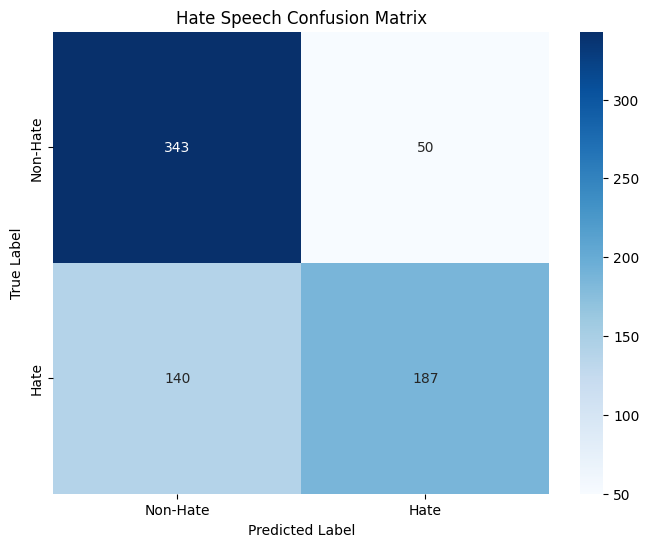


Target Classification Metrics (Hate Cases Only)
              precision    recall  f1-score   support

    Politics       0.72      0.86      0.78       125
   Ethnicity       0.86      0.75      0.80       135
        Race       0.75      0.69      0.72        67

    accuracy                           0.78       327
   macro avg       0.78      0.76      0.77       327
weighted avg       0.78      0.78      0.78       327



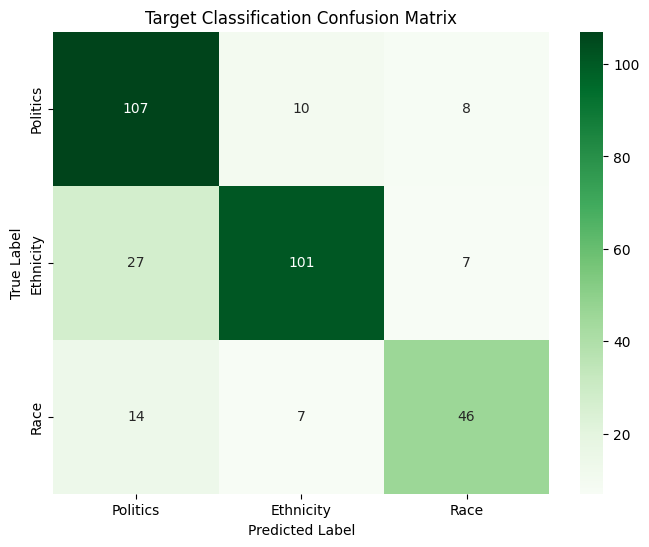

/var/folders/wb/2d5zv5zx3sb06ttllws04nz80000gn/T/ipykernel_4100/1869844281.py:73: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


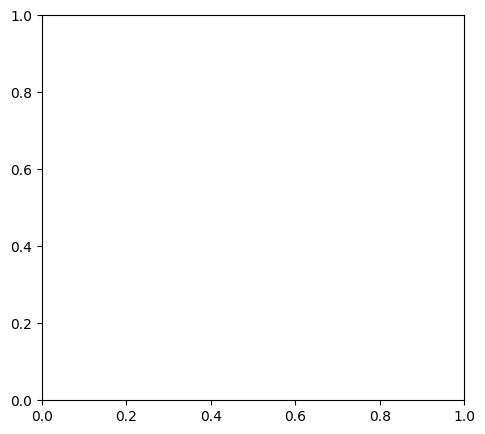

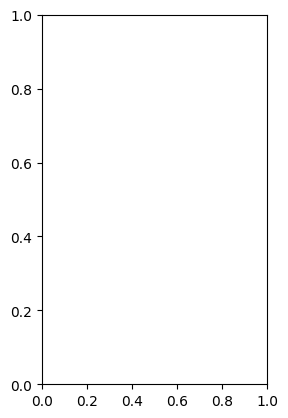

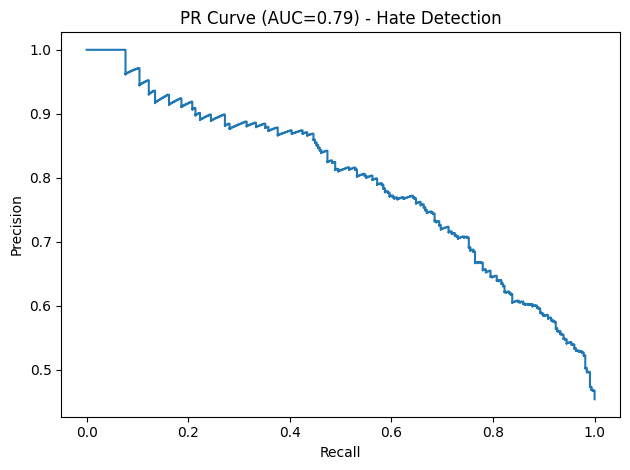

In [53]:
evaluate_and_visualize(trained_model, test_loader, device)
torch.save(trained_model.state_dict(), 'final_model.pth')

In [54]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_scores, title="ROC Curve - Hate Detection", save_path=None):

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

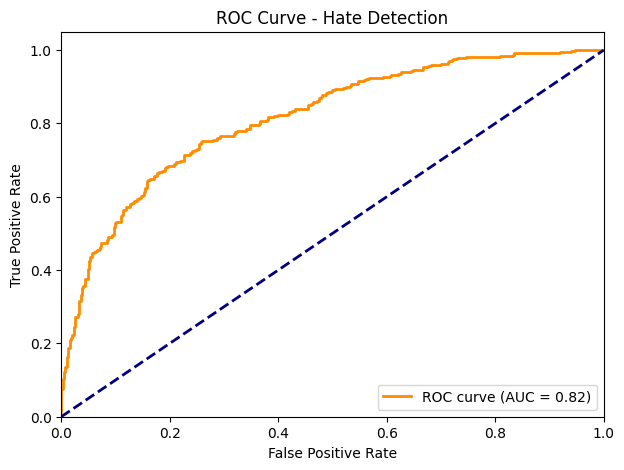

In [55]:
test_metrics = evaluate_model(trained_model, test_loader, device)
plot_roc_curve(test_metrics['true_hate'], test_metrics['hate_probs'])